In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 32

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


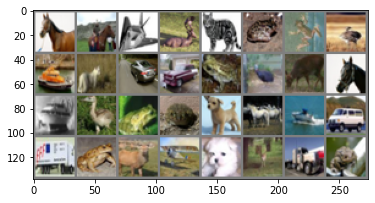

horse horse plane  deer   cat  frog  frog  bird  ship   cat   car   car  frog  bird  deer horse  ship  bird  frog  frog   dog horse  ship   car truck  frog  deer plane   dog  deer truck  frog


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [4]:
device = torch.device("cuda")

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.bn1 = nn.BatchNorm2d(6)
        self.bn2 = nn.BatchNorm2d(16)        

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.bn1(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.bn2(x)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net().to(device)

In [6]:
class LabelSmoothingLoss(nn.Module): 
    def __init__(self, classes, smoothing=0.0, dim=-1): 
        super(LabelSmoothingLoss, self).__init__() 
        self.confidence = 1.0 - smoothing 
        self.smoothing = smoothing 
        self.cls = classes 
        self.dim = dim 

    def forward(self, pred, target): 
        pred = pred.log_softmax(dim=self.dim) 
        with torch.no_grad(): 
            # true_dist = pred.data.clone() 
            true_dist = torch.zeros_like(pred) 
            true_dist.fill_(self.smoothing / (self.cls - 1)) 
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence) 

        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))


In [7]:
target = torch.tensor([6, 0, 1, 4])
target = target.view(2,-1)
target
# target.data.unsqueeze(1)

tensor([[6, 0],
        [1, 4]])

In [8]:
true_dist = torch.zeros_like(torch.randn([2,10])) 
true_dist.fill_(0.01) 
true_dist.scatter_(1, target.data, 0.8) 
true_dist

tensor([[0.8000, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.8000, 0.0100, 0.0100,
         0.0100],
        [0.0100, 0.8000, 0.0100, 0.0100, 0.8000, 0.0100, 0.0100, 0.0100, 0.0100,
         0.0100]])

In [9]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
criterion = LabelSmoothingLoss(classes=10).to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [10]:
def test() :
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)            
#             _, c, h, w = (images.shape)
#             images = torch.cat([images, images], dim=0).view(-1, 2*c, h, w)
    #         print(images.shape)
            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))

In [11]:
for epoch in range(20):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)           

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
    test()

print('Finished Training')

Accuracy of the network on the 10000 test images: 55 %
Accuracy of the network on the 10000 test images: 59 %
Accuracy of the network on the 10000 test images: 63 %
Accuracy of the network on the 10000 test images: 64 %
Accuracy of the network on the 10000 test images: 64 %
Accuracy of the network on the 10000 test images: 64 %
Accuracy of the network on the 10000 test images: 64 %
Accuracy of the network on the 10000 test images: 65 %
Accuracy of the network on the 10000 test images: 64 %
Accuracy of the network on the 10000 test images: 64 %
Accuracy of the network on the 10000 test images: 64 %
Accuracy of the network on the 10000 test images: 63 %
Accuracy of the network on the 10000 test images: 63 %
Accuracy of the network on the 10000 test images: 63 %
Accuracy of the network on the 10000 test images: 64 %
Accuracy of the network on the 10000 test images: 62 %
Accuracy of the network on the 10000 test images: 63 %
Accuracy of the network on the 10000 test images: 62 %
Accuracy o

In [12]:
# correct = 0
# total = 0
# # since we're not training, we don't need to calculate the gradients for our outputs
# with torch.no_grad():
#     for data in testloader:
#         images, labels = data
#         # calculate outputs by running images through the network
#         outputs = net(images)
#         # the class with the highest energy is what we choose as prediction
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

# print('Accuracy of the network on the 10000 test images: %d %%' % (
#     100 * correct / total))